<a href="https://colab.research.google.com/github/muhammadrafdi23145-art/FinalProject/blob/main/Prediksi_Harga_Saham_BBRI_Hplus1_Berdasarkan_selisih_kenaikan_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Library & Setup**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Drive (Jika belum)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Loading & Feature Engineering (The Fix)**

In [13]:
# Load Data
file_path = "/content/drive/MyDrive/Stupen Data Science/Final Project/BBRI.csv"
df = pd.read_csv(file_path)

# Convert Timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

print("--- Menyiapkan Fitur Stationary (Selisih/Return) ---")

# 1. Hitung Logaritma Harga (Agar distribusi normal)
df['Open_Log']   = np.log(df['open'])
df['High_Log']   = np.log(df['high'])
df['Low_Log']    = np.log(df['low'])
df['Close_Log']  = np.log(df['close'])
df['Volume_Log'] = np.log(df['volume'] + 1)
df['MA5_Log']    = df['Close_Log'].rolling(5).mean()

# 2. TARGET: Return Besok (Log Harga Besok - Log Harga Hari Ini)
# Kita memprediksi seberapa besar harga akan NAIK/TURUN, bukan angka harganya.
df['Target_Return'] = df['Close_Log'].shift(-1) - df['Close_Log']

# 3. FITUR INPUT (Juga harus berupa selisih/rasio)
# a. Return Harian (Close hari ini - Close kemarin)
df['Feat_Return_1d'] = df['Close_Log'] - df['Close_Log'].shift(1)

# b. Intraday Change (Close - Open)
df['Feat_Close_Open'] = df['Close_Log'] - df['Open_Log']

# c. Volatilitas (High - Low)
df['Feat_High_Low'] = df['High_Log'] - df['Low_Log']

# d. Tren Jangka Pendek (Jarak Close ke MA5)
df['Feat_Dist_MA5'] = df['Close_Log'] - df['MA5_Log']

# e. Perubahan Volume (Volume hari ini - Volume kemarin)
df['Feat_Vol_Change'] = df['Volume_Log'] - df['Volume_Log'].shift(1)

# Hapus NaN akibat shifting
df.dropna(inplace=True)

print(f"Data siap: {len(df)} baris.")
df.head()

--- Menyiapkan Fitur Stationary (Selisih/Return) ---
Data siap: 4995 baris.


,timestamp,open,low,high,close,volume,Open_Log,High_Log,Low_Log,Close_Log,Volume_Log,MA5_Log,Target_Return,Feat_Return_1d,Feat_Close_Open,Feat_High_Low,Feat_Dist_MA5,Feat_Vol_Change
4,2003-11-14,105,100,105,105,1725265000,4.653960,4.653960,4.605170,4.653960,21.268646,4.628352,-0.048790,0.000000,0.000000,0.048790,0.025608,0.371385
5,2003-11-17,102,100,102,100,423505000,4.624973,4.624973,4.605170,4.605170,19.864076,4.634444,-0.030459,-0.048790,-0.019803,0.019803,-0.029274,-1.404571
6,2003-11-18,100,97,100,97,398055000,4.605170,4.605170,4.574711,4.574711,19.802101,4.628352,0.030459,-0.030459,-0.030459,0.030459,-0.053641,-0.061975
7,2003-11-19,97,97,100,100,277445000,4.574711,4.605170,4.574711,4.605170,19.441133,4.618594,0.019803,0.030459,0.030459,0.030459,-0.013424,-0.360967
8,2003-11-20,100,100,102,102,846315000,4.605170,4.624973,4.605170,4.624973,20.556402,4.612797,0.028988,0.019803,0.019803,0.019803,0.012176,1.115269


**Splitting & Scaling**

In [14]:
# Definisi Fitur dan Target
features = ['Feat_Return_1d', 'Feat_Close_Open', 'Feat_High_Low',
            'Feat_Dist_MA5', 'Feat_Vol_Change']

X = df[features]
y = df['Target_Return'] # Target kita sekarang adalah Return

# Split Data (80% Train, 20% Test) - Tanpa Shuffle (Time Series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Simpan Log Harga Asli untuk Keperluan Evaluasi (Mengembalikan ke Rupiah)
# Kita butuh harga hari ini untuk menghitung: Harga_Besok = Harga_Hari_Ini * exp(Prediksi_Return)
test_dates = df.loc[X_test.index, 'timestamp']
test_price_today_log = df.loc[X_test.index, 'Close_Log']
test_price_next_actual = np.exp(df.loc[X_test.index, 'Close_Log'].shift(-1)) # Harga Asli Besok (Target Real)

# Scaling (Penting untuk SVR dan Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Kembalikan ke DataFrame agar nama kolom aman
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=features)

print("Data berhasil di-split dan di-scaling.")

Data berhasil di-split dan di-scaling.


**Training 3 Model (LR, RF, SVR)**

In [15]:
models = {}
predictions_return = {} # Menyimpan prediksi dalam bentuk Return

# --- 1. Linear Regression ---
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
predictions_return['Linear Regression'] = lr.predict(X_test_scaled)
models['Linear Regression'] = lr
print("Linear Regression Selesai.")

# --- 2. Random Forest (Sekarang sudah Optimal!) ---
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,      # Biarkan tumbuh penuh karena fitur sudah bersih
    min_samples_leaf=2,  # Sedikit regularization
    random_state=42
)
rf.fit(X_train, y_train) # RF bisa pakai data non-scaled
predictions_return['Random Forest'] = rf.predict(X_test)
models['Random Forest'] = rf
print("Random Forest Selesai.")

# --- 3. SVR (Support Vector Regression) ---
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.001)
svr.fit(X_train_scaled, y_train)
predictions_return['SVR'] = svr.predict(X_test_scaled)
models['SVR'] = svr
print("SVR Selesai.")

Linear Regression Selesai.
Random Forest Selesai.
SVR Selesai.


**Evaluasi & Konversi ke Rupiah**

In [16]:
results_rupiah = {}
price_predictions = {} # Menyimpan prediksi harga (Rupiah) untuk plot

print("\n========== HASIL EVALUASI (DALAM RUPIAH) ==========")

for name, pred_return in predictions_return.items():
    # RUMUS REKONSTRUKSI:
    # Log_Harga_Besok = Log_Harga_Hari_Ini + Prediksi_Return
    pred_log_next = test_price_today_log + pred_return

    # Harga_Besok = exp(Log_Harga_Besok)
    pred_price_next = np.exp(pred_log_next)
    price_predictions[name] = pred_price_next

    # Evaluasi dengan Harga Asli Besok (Shifted)
    # Kita harus membuang baris terakhir karena shift(-1) membuat NaN di data asli
    # Tapi karena kita pakai y_test yang sudah selaras, kita pakai y_test index untuk ambil harga asli
    # Cara paling aman: Ambil harga Close asli pada H+1
    actual_price = np.exp(df.loc[X_test.index, 'Close_Log'].shift(-1))

    # Drop NaN terakhir (baris terakhir test set tidak punya 'besok')
    valid_idx = ~np.isnan(actual_price)
    y_true_valid = actual_price[valid_idx]
    y_pred_valid = pred_price_next[valid_idx]

    rmse = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
    mae  = mean_absolute_error(y_true_valid, y_pred_valid)
    r2   = r2_score(y_true_valid, y_pred_valid)

    results_rupiah[name] = {'RMSE (Rp)': rmse, 'MAE (Rp)': mae, 'R2 Score': r2}

    print(f"\nModel: {name}")
    print(f"RMSE : Rp {rmse:,.2f}")
    print(f"R2   : {r2:.4f}")

# Tampilkan Tabel Ringkasan
results_df = pd.DataFrame(results_rupiah).T
print("\n--- RINGKASAN PERBANDINGAN ---")
print(results_df.sort_values(by='RMSE (Rp)'))


========== HASIL EVALUASI (DALAM RUPIAH) ==========

Model: Linear Regression
RMSE : Rp 81.03
R2   : 0.9783

Model: Random Forest
RMSE : Rp 83.25
R2   : 0.9771

Model: SVR
RMSE : Rp 135.33
R2   : 0.9395

--- RINGKASAN PERBANDINGAN ---
                    RMSE (Rp)   MAE (Rp)  R2 Score
Linear Regression   81.029603  57.530845  0.978314
Random Forest       83.250084  60.323910  0.977110
SVR                135.334211  72.232950  0.939508


**Visualisasi (200 Hari Terakhir)**

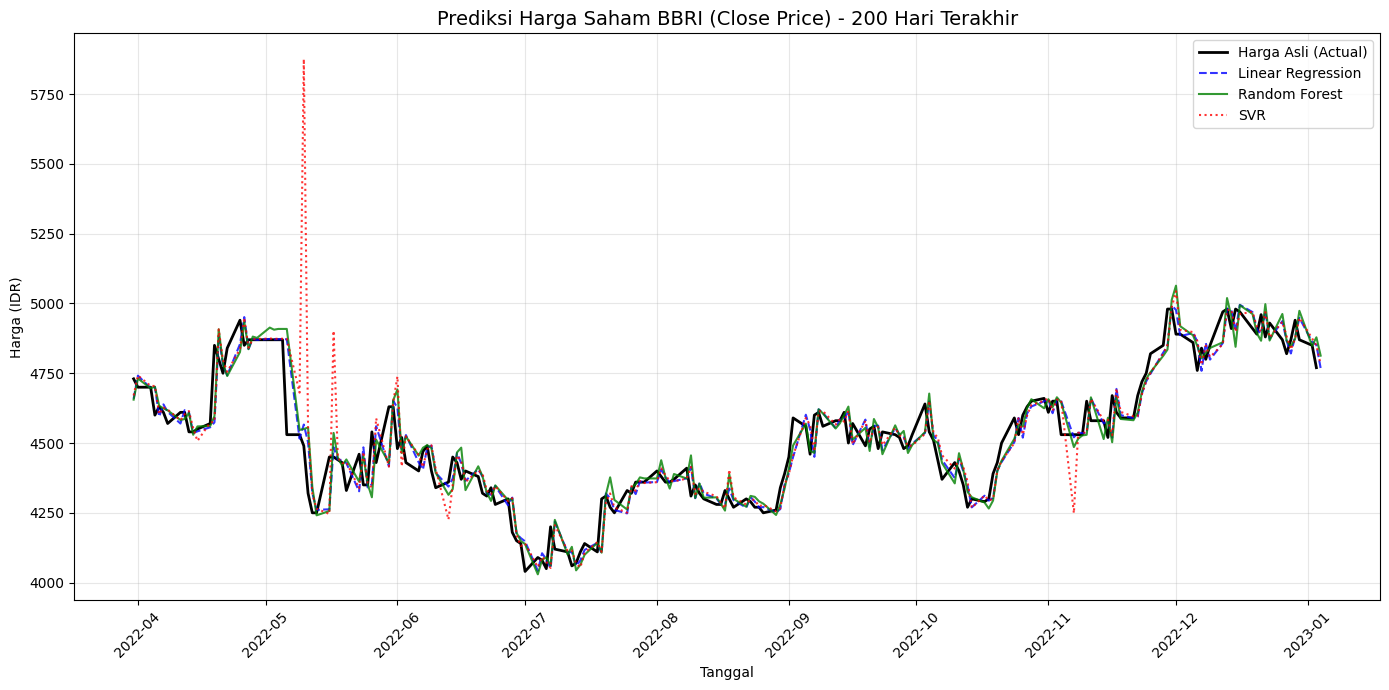

In [17]:
last_n = 200
# Ambil data valid saja (buang NaN terakhir)
valid_dates = test_dates[:-1]
valid_actual = np.exp(df.loc[X_test.index[:-1], 'Close_Log'].shift(-1))

plt.figure(figsize=(14, 7))

# Plot Harga Asli
plt.plot(valid_dates[-last_n:], valid_actual[-last_n:],
         label='Harga Asli (Actual)', color='black', linewidth=2)

# Plot Prediksi Model
colors = {'Linear Regression': 'blue', 'Random Forest': 'green', 'SVR': 'red'}
styles = {'Linear Regression': '--', 'Random Forest': '-', 'SVR': ':'}

for name, preds in price_predictions.items():
    # Preds juga harus dipotong 1 terakhir
    plt.plot(valid_dates[-last_n:], preds[:-1][-last_n:],
             label=f'{name}', color=colors[name], linestyle=styles[name], alpha=0.8)

plt.title(f'Prediksi Harga Saham BBRI (Close Price) - {last_n} Hari Terakhir', fontsize=14)
plt.xlabel('Tanggal')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Manual Input (Mode Penggunaan)**

In [18]:
import streamlit as st
import numpy as np
import pandas as pd
import math
import pickle

# =======================
#  LOAD MODEL & SCALER
# =======================
# Sesuaikan dengan nama file pickle kamu
# Save the models and scaler first (this part needs to be run once)
with open("models.pkl", "wb") as f:
    pickle.dump(models, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


with open("models.pkl", "rb") as f:
    models = pickle.load(f)

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# =======================
#      UI STREAMLIT
# =======================

st.title("Prediksi Harga Saham BBRI H+1")
st.write("Aplikasi ini menghitung dan memprediksi harga BBRI untuk besok (H+1) menggunakan 3 model: Linear Regression, Random Forest, dan SVR.")

st.subheader("Input Data Hari Ini")

open_val  = st.number_input("Open Hari Ini", min_value=0.0, value=5000.0)
high_val  = st.number_input("High Hari Ini", min_value=0.0, value=5050.0)
low_val   = st.number_input("Low Hari Ini", min_value=0.0, value=4980.0)
close_val = st.number_input("Close Hari Ini", min_value=0.0, value=5020.0)
vol_val   = st.number_input("Volume Hari Ini", min_value=0.0, value=1000000.0)

st.subheader("Data Tambahan")
prev_close = st.number_input("Close Kemarin", min_value=0.0, value=5000.0)
prev_vol   = st.number_input("Volume Kemarin", min_value=0.0, value=1000000.0)
ma5_val    = st.number_input("MA 5 Hari", min_value=0.0, value=5010.0)

# =======================
#   PREDIKSI HARGA
# =======================

if st.button("Prediksi Harga Besok (H+1)"):

    # Logaritma
    log_open  = np.log(open_val)
    log_high  = np.log(high_val)
    log_low   = np.log(low_val)
    log_close = np.log(close_val)
    log_vol   = np.log(vol_val + 1)
    log_prev_close = np.log(prev_close)
    log_prev_vol   = np.log(prev_vol + 1)
    log_ma5 = np.log(ma5_val)

    # Fitur Selisih
    feat_return_1d  = log_close - log_prev_close
    feat_close_open = log_close - log_open
    feat_high_low   = log_high - log_low
    feat_dist_ma5   = log_close - log_ma5
    feat_vol_change = log_vol - log_prev_vol

    # DataFrame Input
    input_df = pd.DataFrame([{
        'Feat_Return_1d': feat_return_1d,
        'Feat_Close_Open': feat_close_open,
        'Feat_High_Low': feat_high_low,
        'Feat_Dist_MA5': feat_dist_ma5,
        'Feat_Vol_Change': feat_vol_change
    }])

    # Scaling untuk LR & SVR
    input_scaled = scaler.transform(input_df)

    # Prediksi return
    pred_ret_lr  = models['Linear Regression'].predict(input_scaled)[0]
    pred_ret_rf  = models['Random Forest'].predict(input_df)[0]
    pred_ret_svr = models['SVR'].predict(input_scaled)[0]

    # Konversi return → harga
    price_lr  = close_val * np.exp(pred_ret_lr)
    price_rf  = close_val * np.exp(pred_ret_rf)
    price_svr = close_val * np.exp(pred_ret_svr)

    st.subheader("Hasil Prediksi Harga Besok (H+1)")
    st.write(f"**Harga Close Hari Ini:** Rp {close_val:,.0f}")

    st.success(f"Linear Regression: Rp {price_lr:,.0f}  (Perubahan: {pred_ret_lr*100:.2f}%)")
    st.info(f"Random Forest: Rp {price_rf:,.0f}  (Perubahan: {pred_ret_rf*100:.2f}%)")
    st.warning(f"SVR: Rp {price_svr:,.0f}  (Perubahan: {pred_ret_svr*100:.2f}%)")

2025-12-09 08:20:07.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 08:20:07.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 08:20:07.657 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 08:20:07.659 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 08:20:07.661 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 08:20:07.662 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 08:20:07.664 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 08:20:07.665 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar